# Fixed

In [1]:
# Database and Collections
from src.domain.Query import JobQuery, MachineQuery
from src.domain.Collection import LiveJobCollection


In [2]:
import pandas as pd
from decimal import Decimal

from matplotlib import pyplot as plt

from src.Logger import Logger

# DataFrame analyses
from src.DataFrameAnalyses import DataFramePlotGenerator, DataFrameChecker, DataFrameMetricsAnalyser

# Analysis utils
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.CP_Solver import Solver

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from config.project_config import get_examples_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [3]:
# Hard termination condition for schedulers
max_time = 60*15     # 15 min

# File paths
examples_path = get_examples_path("Fixed_with_Transition_Time", as_string= True)

# Simulation
simulation = ProductionSimulation(shift_length= 1440, sigma = 0.2)

# Logger
logger = Logger(log_file = f"{examples_path}/experiment_logger.log")

In [4]:
# Jobs for 6 days (shifts)
timespan = 60*24*6

jobs = JobQuery.get_by_source_name_max_util_and_lt_arrival(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization = Decimal("0.95"),
    arrival_limit= timespan
)
#jobs = [job for job in all_jobs if job.earliest_start <=timespan]

jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,0,1440,3326
1,01-09500-0001,01-06,47,1440,3649
2,01-09500-0002,01-01,112,1440,3135
3,01-09500-0003,01-05,155,1440,5310
4,01-09500-0004,01-04,196,1440,3015
5,01-09500-0005,01-02,396,1440,2639
...,...,...,...,...,...
134,01-09500-0134,01-01,8350,8640,12090
135,01-09500-0135,01-02,8497,8640,11348
136,01-09500-0136,01-03,8547,8640,10995


In [5]:
for job in list(jobs_collection.values())[:2]:
    print(f"{job.id = }")
    for operation in job.operations:
        print(f" {operation.position_number = } {operation.machine_name = } {operation.transition_time = }")

job.id = '01-09500-0000'
 operation.position_number = 0 operation.machine_name = 'M02' operation.transition_time = 0
 operation.position_number = 1 operation.machine_name = 'M00' operation.transition_time = 0
 operation.position_number = 2 operation.machine_name = 'M01' operation.transition_time = 0
 operation.position_number = 3 operation.machine_name = 'M05' operation.transition_time = 0
 operation.position_number = 4 operation.machine_name = 'M04' operation.transition_time = 0
 operation.position_number = 5 operation.machine_name = 'M06' operation.transition_time = 0
 operation.position_number = 6 operation.machine_name = 'M08' operation.transition_time = 0
 operation.position_number = 7 operation.machine_name = 'M09' operation.transition_time = 0
 operation.position_number = 8 operation.machine_name = 'M07' operation.transition_time = 0
 operation.position_number = 9 operation.machine_name = 'M03' operation.transition_time = 0
job.id = '01-09500-0001'
 operation.position_number = 0

### Add transition times to operations (not saved in DB)

In [6]:
machines = MachineQuery.get_machines(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization=Decimal("0.95")
)

for machine in machines:
    print(machine)

Machine(id=41, source_id=1, name='M00', max_bottleneck_utilization=Decimal('0.9500'), transition_time=225)
Machine(id=42, source_id=1, name='M01', max_bottleneck_utilization=Decimal('0.9500'), transition_time=480)
Machine(id=43, source_id=1, name='M02', max_bottleneck_utilization=Decimal('0.9500'), transition_time=176)
Machine(id=44, source_id=1, name='M03', max_bottleneck_utilization=Decimal('0.9500'), transition_time=442)
Machine(id=45, source_id=1, name='M04', max_bottleneck_utilization=Decimal('0.9500'), transition_time=97)
Machine(id=46, source_id=1, name='M05', max_bottleneck_utilization=Decimal('0.9500'), transition_time=98)
Machine(id=47, source_id=1, name='M06', max_bottleneck_utilization=Decimal('0.9500'), transition_time=59)
Machine(id=48, source_id=1, name='M07', max_bottleneck_utilization=Decimal('0.9500'), transition_time=93)
Machine(id=49, source_id=1, name='M08', max_bottleneck_utilization=Decimal('0.9500'), transition_time=89)
Machine(id=50, source_id=1, name='M09', ma

### Add transition times to operations (not saved in DB)

In [7]:
for machine in machines:
    for job in jobs_collection.values():
        for operation in job.operations:
            if operation.machine_name == machine.name:
                operation.transition_time = machine.transition_time
                # break # if sure that machines do not repeat per job

In [8]:
for job in list(jobs_collection.values())[:2]:
    print(job.id)
    for operation in job.operations:
        print(f" {operation.position_number = } {operation.machine_name = } {operation.transition_time = }")

01-09500-0000
 operation.position_number = 0 operation.machine_name = 'M02' operation.transition_time = 176
 operation.position_number = 1 operation.machine_name = 'M00' operation.transition_time = 225
 operation.position_number = 2 operation.machine_name = 'M01' operation.transition_time = 480
 operation.position_number = 3 operation.machine_name = 'M05' operation.transition_time = 98
 operation.position_number = 4 operation.machine_name = 'M04' operation.transition_time = 97
 operation.position_number = 5 operation.machine_name = 'M06' operation.transition_time = 59
 operation.position_number = 6 operation.machine_name = 'M08' operation.transition_time = 89
 operation.position_number = 7 operation.machine_name = 'M09' operation.transition_time = 29
 operation.position_number = 8 operation.machine_name = 'M07' operation.transition_time = 93
 operation.position_number = 9 operation.machine_name = 'M03' operation.transition_time = 442
01-09500-0001
 operation.position_number = 0 operati

## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [9]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [10]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)

In [11]:
current_jobs_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,0,M02,None,31,None,0,1440,3326
1,01-09500-0000,01-07,1,M00,None,86,None,0,1440,3326
2,01-09500-0000,01-07,2,M01,None,46,None,0,1440,3326
3,01-09500-0000,01-07,3,M05,None,74,None,0,1440,3326
4,01-09500-0000,01-07,4,M04,None,32,None,0,1440,3326
5,01-09500-0000,01-07,5,M06,None,88,None,0,1440,3326
...,...,...,...,...,...,...,...,...,...,...
164,01-09500-0016,01-07,4,M04,None,32,None,1345,1440,4197
165,01-09500-0016,01-07,5,M06,None,88,None,1345,1440,4197
166,01-09500-0016,01-07,6,M08,None,19,None,1345,1440,4197


In [12]:
current_jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,0,1440,3326
1,01-09500-0001,01-06,47,1440,3649
2,01-09500-0002,01-01,112,1440,3135
3,01-09500-0003,01-05,155,1440,5310
4,01-09500-0004,01-04,196,1440,3015
5,01-09500-0005,01-02,396,1440,2639
...,...,...,...,...,...
11,01-09500-0011,01-02,901,1440,3991
12,01-09500-0012,01-08,970,1440,3294
13,01-09500-0013,01-04,1054,1440,4643


### Scheduling

In [13]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start,
    logger = logger
)


solver.build_model__absolute_lateness__with_fix_order_on_machines(
    previous_schedule_jobs_collection= None,
    active_jobs_collection= None,
    w_t= 3, w_e = 1
)
solver.log_model_info()


2025-09-09 05:47:51 INFO: Building model: minimal fix-order-on-machines + new-after
2025-09-09 05:47:51 INFO: Model info ---------------
2025-09-09 05:47:51 INFO: Number of preparable operations: 170
2025-09-09 05:47:51 INFO: Number of previous operations  : 0
2025-09-09 05:47:51 INFO: Number of active operation     : 0
2025-09-09 05:47:51 INFO: Number of variables            : 374
2025-09-09 05:47:51 INFO: Number of constraints          : 384


In [14]:
solver.solve_model(
    log_file= f"{examples_path}/cp_solver_01_init.log",
    gap_limit= 0.00,
    time_limit= max_time,
    bound_relative_change= 0.01,
    bound_no_improvement_time= 60,
    bound_warmup_time=60,
)
solver.log_solver_info()

2025-09-09 05:47:51 INFO: Solver info --------------
2025-09-09 05:47:51 INFO: Status              : OPTIMAL
2025-09-09 05:47:51 INFO: Objective value     : 0.0
2025-09-09 05:47:51 INFO: Best objective bound: 0.0
2025-09-09 05:47:51 INFO: Number of branches  : 39
2025-09-09 05:47:51 INFO: Wall time           : 0.02
2025-09-09 05:47:51 INFO: Tardiness cost      : 0
2025-09-09 05:47:51 INFO: Earliness cost      : 0
2025-09-09 05:47:51 INFO: Deviation cost      : 0


In [15]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(f"{examples_path}/schedule_day_01.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,0,M02,1454,31,1485,0,1440,3326
1,01-09500-0000,01-07,1,M00,1650,86,1736,0,1440,3326
2,01-09500-0000,01-07,2,M01,1820,46,1866,0,1440,3326
3,01-09500-0000,01-07,3,M05,1895,74,1969,0,1440,3326
4,01-09500-0000,01-07,4,M04,1969,32,2001,0,1440,3326
5,01-09500-0000,01-07,5,M06,2001,88,2089,0,1440,3326
...,...,...,...,...,...,...,...,...,...,...
164,01-09500-0016,01-07,4,M04,2507,32,2539,1345,1440,4197
165,01-09500-0016,01-07,5,M06,2580,88,2668,1345,1440,4197
166,01-09500-0016,01-07,6,M08,2668,19,2687,1345,1440,4197


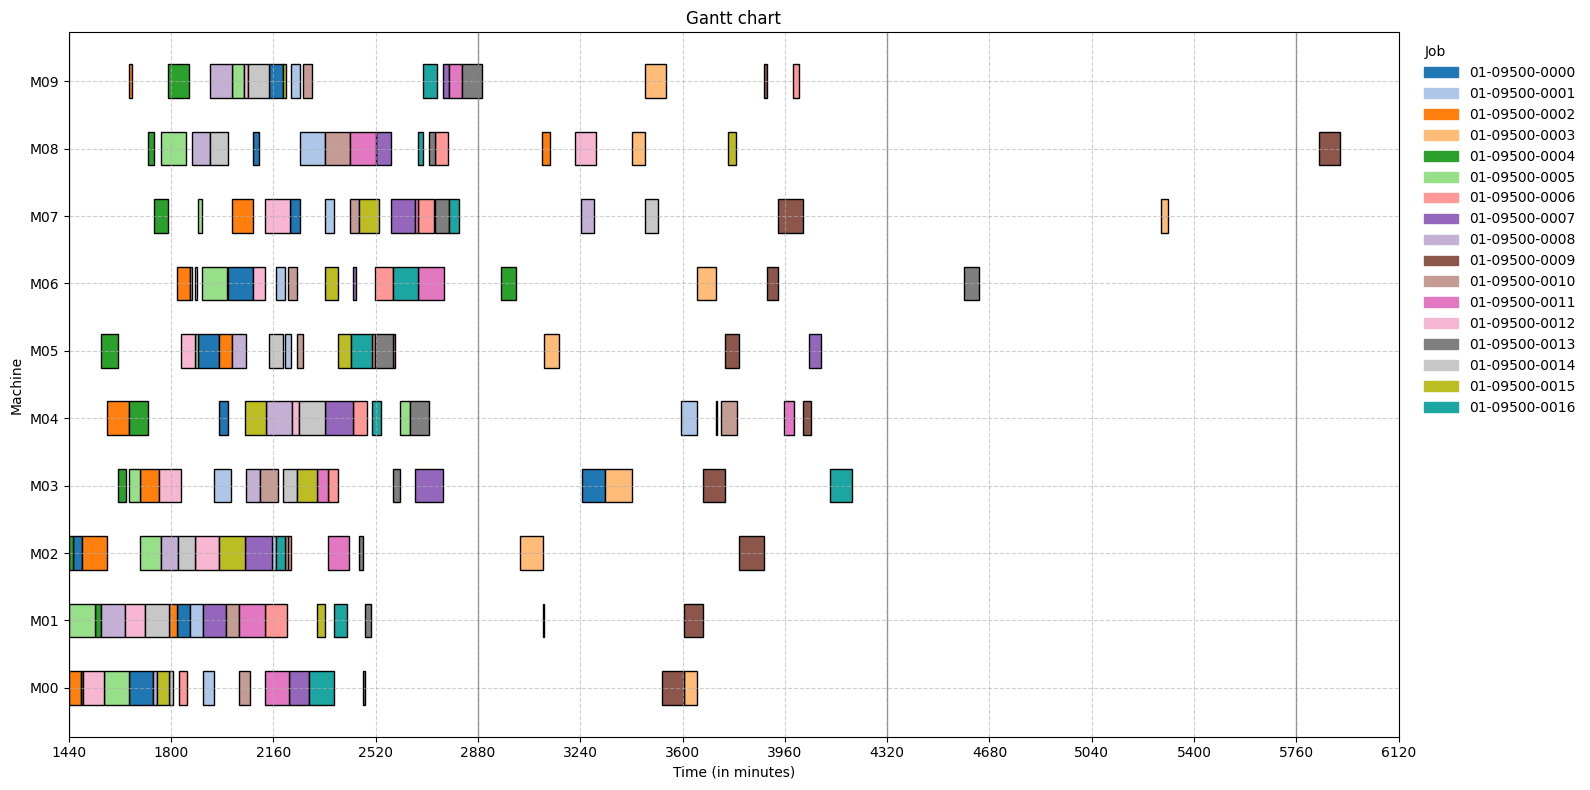

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [16]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)


In [17]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
df_jobs_metrics

,Job,Routing_ID,Last Operation,End,Arrival,Ready Time,Due Date,Total Processing Time,Flowtime,Lateness,Tardiness,Earliness
0,01-09500-0000,01-07,9,3326,0,1440,3326,539,1886,0,0,0
1,01-09500-0001,01-06,9,3649,47,1440,3649,416,2209,0,0,0
2,01-09500-0002,01-01,9,3135,112,1440,3135,510,1695,0,0,0
3,01-09500-0003,01-05,9,5310,155,1440,5310,496,3870,0,0,0
4,01-09500-0004,01-04,9,3015,196,1440,3015,393,1575,0,0,0
5,01-09500-0005,01-02,9,2639,396,1440,2639,568,1199,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11,01-09500-0011,01-02,9,3991,901,1440,3991,568,2551,0,0,0
12,01-09500-0012,01-08,9,3294,970,1440,3294,597,1854,0,0,0
13,01-09500-0013,01-04,9,4643,1054,1440,4643,393,3203,0,0,0


In [18]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,17,0,0,0


In [19]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,0,17,0,0,0


### Simulation

In [20]:
# simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)
simulation.initialize_run(schedule_collection = schedule_jobs_collection, start_time=day_start)

[Day 1 00:00:00] Job 01-09500-0002 started on M00
[Day 1 00:00:00] Job 01-09500-0004 started on M02
[Day 1 00:00:00] Job 01-09500-0005 started on M01
[Day 1 00:20:00] Job 01-09500-0004 finished on M02 (after 20 minutes)
[Day 1 00:20:00] Job 01-09500-0000 started on M02
[Day 1 00:31:00] Job 01-09500-0002 finished on M00 (after 31 minutes)
[Day 1 00:43:00] Job 01-09500-0004 started on M00
[Day 1 00:48:00] Job 01-09500-0004 finished on M00 (after 05 minutes)
[Day 1 00:49:00] Job 01-09500-0012 started on M00
[Day 1 00:53:00] Job 01-09500-0000 finished on M02 (after 33 minutes)
[Day 1 00:53:00] Job 01-09500-0002 started on M02
[Day 1 01:14:00] Job 01-09500-0005 finished on M01 (after 74 minutes)
[Day 1 01:31:00] Job 01-09500-0004 started on M01
[Day 1 01:47:00] Job 01-09500-0004 finished on M01 (after 16 minutes)
[Day 1 01:53:00] Job 01-09500-0008 started on M01
[Day 1 01:53:00] Job 01-09500-0004 started on M05
[Day 1 01:58:00] Job 01-09500-0012 finished on M00 (after 69 minutes)
[Day 1 02:

In [21]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_operations_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0004,01-04,0,M02,1440.0,20.0,1460.0,196,1440,3015
1,01-09500-0004,01-04,1,M00,1483.0,5.0,1488.0,196,1440,3015
2,01-09500-0004,01-04,2,M01,1531.0,16.0,1547.0,196,1440,3015
3,01-09500-0004,01-04,3,M05,1553.0,43.0,1596.0,196,1440,3015
4,01-09500-0004,01-04,4,M03,1614.0,23.0,1637.0,196,1440,3015
5,01-09500-0004,01-04,5,M04,1650.0,71.0,1721.0,196,1440,3015
...,...,...,...,...,...,...,...,...,...,...
128,01-09500-0013,01-04,2,M01,2486.0,17.0,2503.0,1054,1440,4643
129,01-09500-0013,01-04,3,M05,2528.0,63.0,2591.0,1054,1440,4643
130,01-09500-0013,01-04,4,M03,2591.0,28.0,2619.0,1054,1440,4643


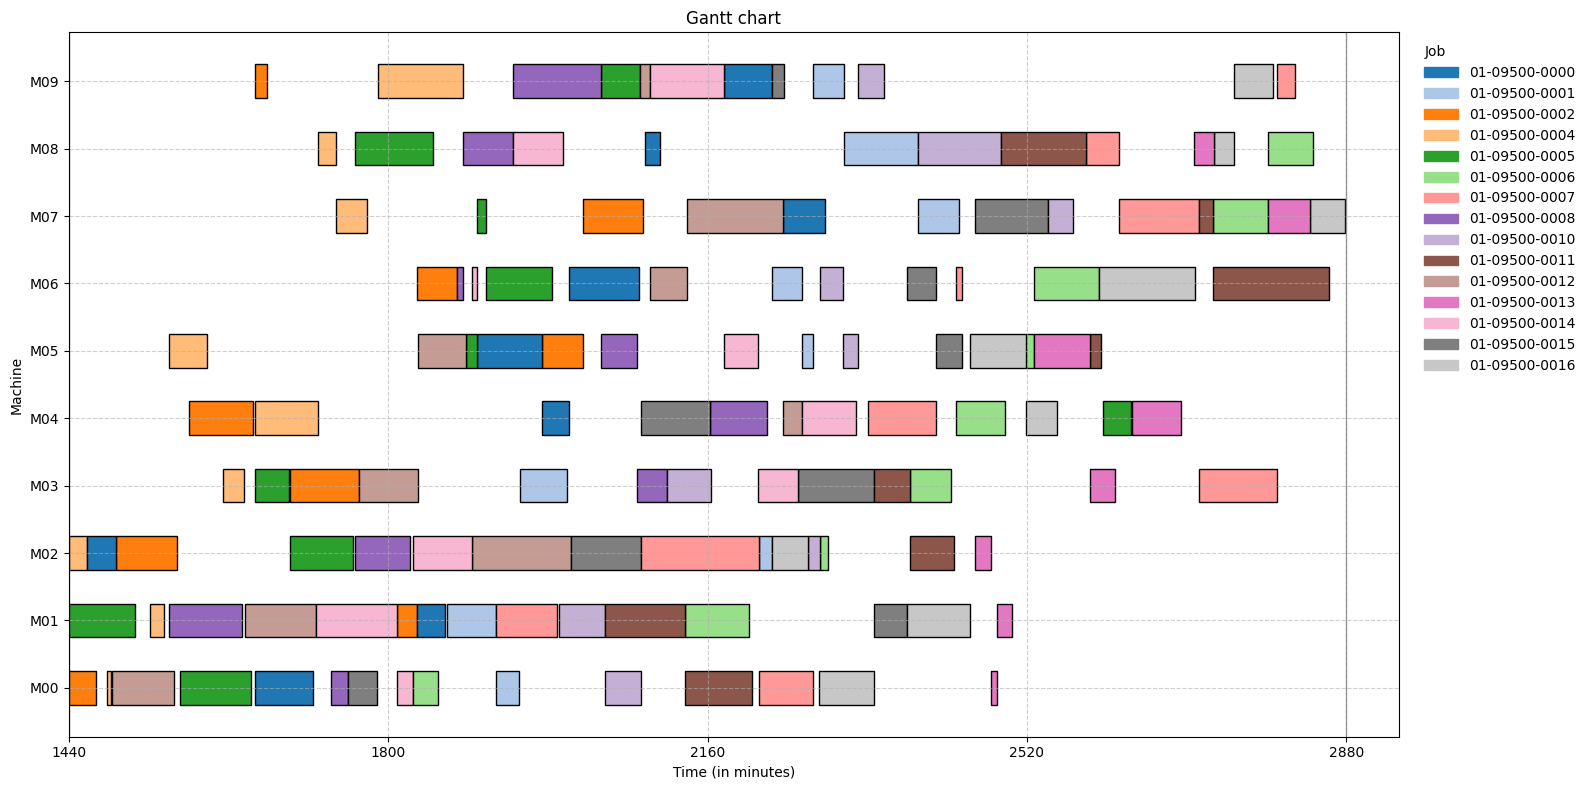

In [22]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution, perspective="Machine")
plt.show()

In [23]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_operations_dataframe()
df_active

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0013,01-04,8,M09,2839.0,90.0,2929.0,1054,1440,4643


In [24]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,9,M03,3247,79,3326,0,1440,3326
1,01-09500-0001,01-06,9,M04,3594,55,3649,47,1440,3649
2,01-09500-0002,01-01,9,M08,3105,30,3135,112,1440,3135
3,01-09500-0003,01-05,0,M02,3026,84,3110,155,1440,5310
4,01-09500-0003,01-05,1,M01,3110,2,3112,155,1440,5310
5,01-09500-0003,01-05,2,M05,3112,52,3164,155,1440,5310
...,...,...,...,...,...,...,...,...,...,...
29,01-09500-0011,01-02,9,M04,3958,33,3991,901,1440,3991
30,01-09500-0012,01-08,9,M08,3220,74,3294,970,1440,3294
31,01-09500-0013,01-04,9,M06,4590,53,4643,1054,1440,4643


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [25]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [26]:
# New and previous jobs that must be scheduled
current_jobs_collection_temp = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_jobs_collection = current_jobs_collection_temp + waiting_job_ops_collection

In [27]:
# Test
current_jobs_collection_temp.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0017,01-05,0,M02,None,84,None,1691,2880,4451
1,01-09500-0017,01-05,1,M01,None,2,None,1691,2880,4451
2,01-09500-0017,01-05,2,M05,None,52,None,1691,2880,4451
3,01-09500-0017,01-05,3,M03,None,95,None,1691,2880,4451
4,01-09500-0017,01-05,4,M08,None,48,None,1691,2880,4451
5,01-09500-0017,01-05,5,M09,None,72,None,1691,2880,4451
...,...,...,...,...,...,...,...,...,...,...
214,01-09500-0038,01-05,4,M08,None,48,None,2740,2880,5805
215,01-09500-0038,01-05,5,M09,None,72,None,2740,2880,5805
216,01-09500-0038,01-05,6,M00,None,47,None,2740,2880,5805


In [28]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,9,M03,3247.0,79,3326.0,0,1440,3326
1,01-09500-0001,01-06,9,M04,3594.0,55,3649.0,47,1440,3649
2,01-09500-0002,01-01,9,M08,3105.0,30,3135.0,112,1440,3135
3,01-09500-0003,01-05,0,M02,3026.0,84,3110.0,155,1440,5310
4,01-09500-0003,01-05,1,M01,3110.0,2,3112.0,155,1440,5310
5,01-09500-0003,01-05,2,M05,3112.0,52,3164.0,155,1440,5310
...,...,...,...,...,...,...,...,...,...,...
249,01-09500-0038,01-05,4,M08,NaN,48,NaN,2740,2880,5805
250,01-09500-0038,01-05,5,M09,NaN,72,NaN,2740,2880,5805
251,01-09500-0038,01-05,6,M00,NaN,47,NaN,2740,2880,5805


In [29]:
# Test
for job in waiting_job_ops_collection.values():
    for operation in job.operations:
            print(operation, operation.transition_time)

JobOperation(job_id='01-09500-0000', position_number=9, machine_name='M03', duration=79) 442
JobOperation(job_id='01-09500-0001', position_number=9, machine_name='M04', duration=55) 97
JobOperation(job_id='01-09500-0002', position_number=9, machine_name='M08', duration=30) 89
JobOperation(job_id='01-09500-0003', position_number=0, machine_name='M02', duration=84) 176
JobOperation(job_id='01-09500-0003', position_number=1, machine_name='M01', duration=2) 480
JobOperation(job_id='01-09500-0003', position_number=2, machine_name='M05', duration=52) 98
JobOperation(job_id='01-09500-0003', position_number=3, machine_name='M03', duration=95) 442
JobOperation(job_id='01-09500-0003', position_number=4, machine_name='M08', duration=48) 89
JobOperation(job_id='01-09500-0003', position_number=5, machine_name='M09', duration=72) 29
JobOperation(job_id='01-09500-0003', position_number=6, machine_name='M00', duration=47) 225
JobOperation(job_id='01-09500-0003', position_number=7, machine_name='M06', 

In [30]:
# Test
for job in current_jobs_collection.values():
    for operation in job.operations:
        if job.id == '01-08500-0003' and operation.position_number == 9:
            print(operation, operation.transition_time)



In [31]:
# Test
for job in current_jobs_collection.values():
    for operation in job.operations:
        if operation.position_number == operation.job.first_operation_position_number: # == 0
            due_date = operation.job_due_date
            left_transition_time = operation.job.sum_transition_time(operation.position_number)
            duration = operation.job.sum_duration
            reasonable_min_start = due_date - duration - left_transition_time
            print(operation, f"{operation.job.earliest_start = }\n\t{reasonable_min_start=} = [ ({due_date=}) - ({duration=}) - ({left_transition_time=})]\n")

JobOperation(job_id='01-09500-0000', position_number=9, machine_name='M03', duration=79) operation.job.earliest_start = 1440
	reasonable_min_start=2805 = [ (due_date=3326) - (duration=79) - (left_transition_time=442)]

JobOperation(job_id='01-09500-0001', position_number=9, machine_name='M04', duration=55) operation.job.earliest_start = 1440
	reasonable_min_start=3497 = [ (due_date=3649) - (duration=55) - (left_transition_time=97)]

JobOperation(job_id='01-09500-0002', position_number=9, machine_name='M08', duration=30) operation.job.earliest_start = 1440
	reasonable_min_start=3016 = [ (due_date=3135) - (duration=30) - (left_transition_time=89)]

JobOperation(job_id='01-09500-0003', position_number=0, machine_name='M02', duration=84) operation.job.earliest_start = 1440
	reasonable_min_start=3026 = [ (due_date=5310) - (duration=496) - (left_transition_time=1788)]

JobOperation(job_id='01-09500-0004', position_number=9, machine_name='M06', duration=53) operation.job.earliest_start = 1440

### Scheduling (Rescheduling)

In [32]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_operations_dataframe()

#### a) Simple Scheduling

In [33]:
solver = Solver(
    jobs_collection=current_jobs_collection,
    schedule_start=day_start,
    logger=logger,
)

solver.build_model__absolute_lateness__with_fix_order_on_machines(
    previous_schedule_jobs_collection=previous_schedule_jobs_collection,             # simple scheduling
    active_jobs_collection=active_job_ops_collection,
    w_t=3, w_e=1
)
solver.log_model_info()

2025-09-09 05:47:54 INFO: Building model: minimal fix-order-on-machines + new-after
2025-09-09 05:47:54 INFO: Model info ---------------
2025-09-09 05:47:54 INFO: Number of preparable operations: 255
2025-09-09 05:47:54 INFO: Number of previous operations  : 170
2025-09-09 05:47:54 INFO: Number of active operation     : 1
2025-09-09 05:47:54 INFO: Number of variables            : 586
2025-09-09 05:47:54 INFO: Number of constraints          : 842


In [34]:
solver.solve_model(
    log_file= f"{examples_path}/cp_solver_02.log",
    gap_limit= 0.00,
    time_limit= max_time,
    bound_relative_change= 0.01,
    bound_no_improvement_time= 300,
    bound_warmup_time=60,
)
solver.log_solver_info()

2025-09-09 06:01:04 INFO: Solver info --------------
2025-09-09 06:01:04 INFO: Status              : FEASIBLE
2025-09-09 06:01:04 INFO: Objective value     : 5314.0
2025-09-09 06:01:04 INFO: Best objective bound: 3799.0
2025-09-09 06:01:04 INFO: Number of branches  : 298
2025-09-09 06:01:04 INFO: Wall time           : 789.78
2025-09-09 06:01:04 INFO: Tardiness cost      : 1344
2025-09-09 06:01:04 INFO: Earliness cost      : 3970
2025-09-09 06:01:04 INFO: Deviation cost      : 0


In [35]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(f"{examples_path}/schedule_day_02_simple.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,9,M03,3247,79,3326,0,1440,3326
1,01-09500-0001,01-06,9,M04,3594,55,3649,47,1440,3649
2,01-09500-0002,01-01,9,M08,3105,30,3135,112,1440,3135
3,01-09500-0003,01-05,0,M02,3026,84,3110,155,1440,5310
4,01-09500-0003,01-05,1,M01,3110,2,3112,155,1440,5310
5,01-09500-0003,01-05,2,M05,3112,52,3164,155,1440,5310
...,...,...,...,...,...,...,...,...,...,...
249,01-09500-0038,01-05,4,M08,5502,48,5550,2740,2880,5805
250,01-09500-0038,01-05,5,M09,5550,72,5622,2740,2880,5805
251,01-09500-0038,01-05,6,M00,5622,47,5669,2740,2880,5805


In [36]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 0 (over 34 shared operations)
Mean Kendall Tau: 1.00


In [37]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

,Original Sequence,Revised Sequence,Levenshtein,Kendall Tau
Machine,,,,
M00,"[01-09500-0009, 01-09500-0003]","[01-09500-0009, 01-09500-0003]",0,1.0
M01,"[01-09500-0003, 01-09500-0009]","[01-09500-0003, 01-09500-0009]",0,1.0
M02,"[01-09500-0003, 01-09500-0009]","[01-09500-0003, 01-09500-0009]",0,1.0
M03,"[01-09500-0000, 01-09500-0003, 01-09500-0009, ...","[01-09500-0000, 01-09500-0003, 01-09500-0009, ...",0,1.0
M04,"[01-09500-0001, 01-09500-0003, 01-09500-0010, ...","[01-09500-0001, 01-09500-0003, 01-09500-0010, ...",0,1.0
M05,"[01-09500-0003, 01-09500-0009, 01-09500-0007]","[01-09500-0003, 01-09500-0009, 01-09500-0007]",0,1.0
M06,"[01-09500-0004, 01-09500-0003, 01-09500-0009, ...","[01-09500-0004, 01-09500-0003, 01-09500-0009, ...",0,1.0
M07,"[01-09500-0008, 01-09500-0014, 01-09500-0009, ...","[01-09500-0008, 01-09500-0014, 01-09500-0009, ...",0,1.0
M08,"[01-09500-0002, 01-09500-0012, 01-09500-0003, ...","[01-09500-0002, 01-09500-0012, 01-09500-0003, ...",0,1.0


In [38]:
df_previous_schedule[
    (df_previous_schedule.Machine == "M04") &
    (df_previous_schedule.Job.isin(['01-09500-0001', '01-09500-0003',
                                    '01-09500-0010', '01-09500-0011',
                                    '01-09500-0009']))
].sort_values("Start")

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
19,01-09500-0001,01-06,9,M04,3594,55,3649,47,1440,3649
38,01-09500-0003,01-05,8,M04,3716,6,3722,155,1440,5310
109,01-09500-0010,01-06,9,M04,3736,55,3791,896,1440,3791
119,01-09500-0011,01-02,9,M04,3958,33,3991,901,1440,3991
98,01-09500-0009,01-08,8,M04,4025,26,4051,876,1440,5913


In [39]:
df_schedule[
    (df_schedule.Machine == "M04") &
    (df_schedule.Job.isin(['01-09500-0001', '01-09500-0003',
                                    '01-09500-0010', '01-09500-0011',
                                    '01-09500-0009']))
].sort_values("Start")

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
1,01-09500-0001,01-06,9,M04,3594,55,3649,47,1440,3649
11,01-09500-0003,01-05,8,M04,3716,6,3722,155,1440,5310
27,01-09500-0010,01-06,9,M04,3736,55,3791,896,1440,3791
29,01-09500-0011,01-02,9,M04,3958,33,3991,901,1440,3991
25,01-09500-0009,01-08,8,M04,4025,26,4051,876,1440,5913


In [40]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,6,3,22,5,1,1


#### Check the conditions of the combined data set from the simulation data with the new schedule

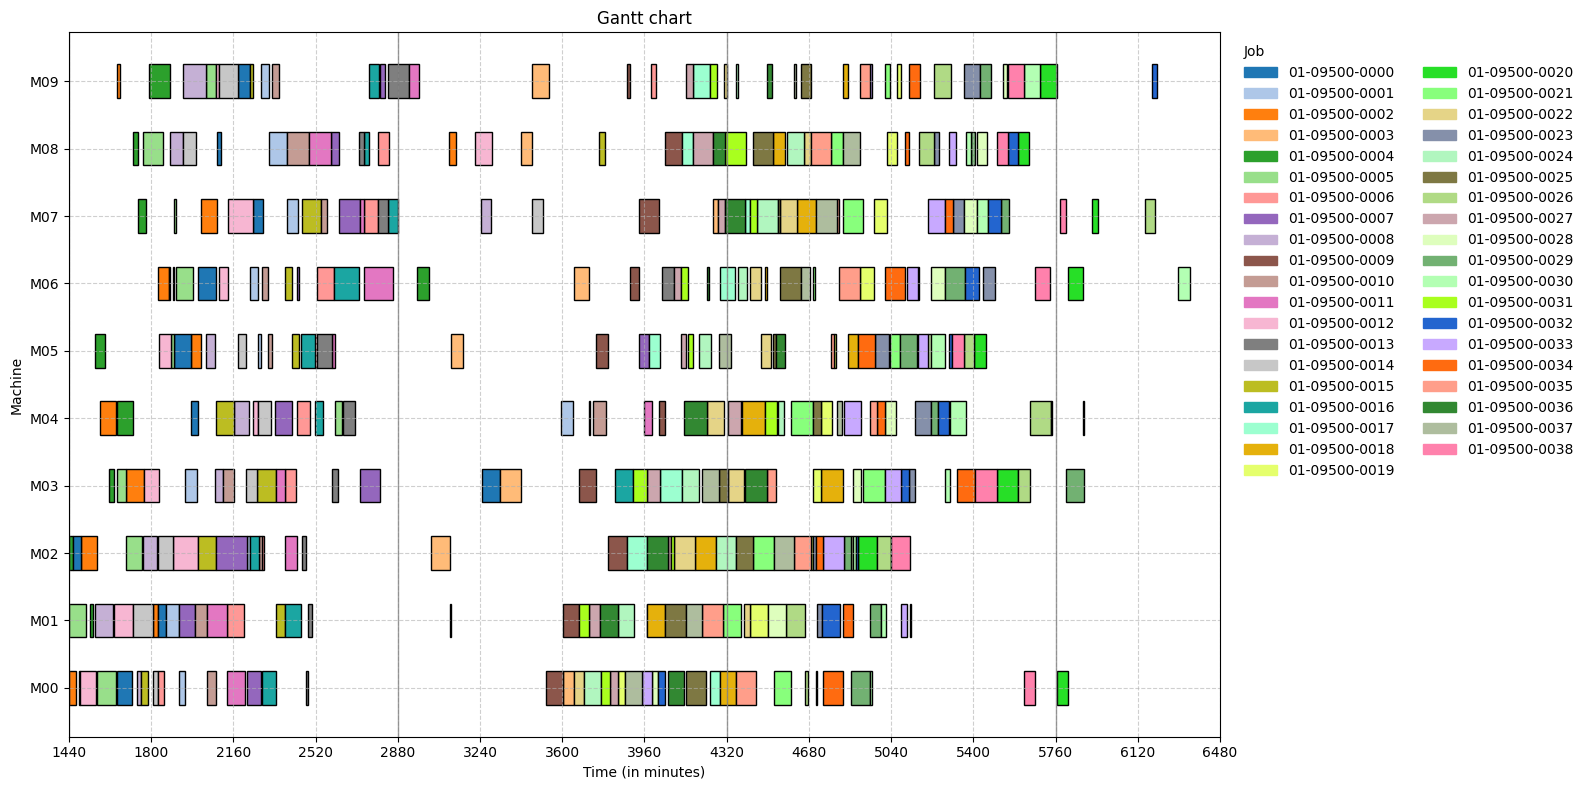

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [41]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)

### Simulation

In [42]:
simulation.run(schedule_collection=schedule_jobs_collection, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job 01-09500-0013, Operation 8 resumed on M09 with 49 minutes left)
[Day 2 00:49:00] Job 01-09500-0013 finished on M09 (after 49 minutes)
[Day 2 00:49:00] Job 01-09500-0011 started on M09
[Day 2 01:22:00] Job 01-09500-0004 started on M06
[Day 2 01:36:00] Job 01-09500-0011 finished on M09 (after 47 minutes)
[Day 2 02:26:00] Job 01-09500-0003 started on M02
[Day 2 02:34:00] Job 01-09500-0004 finished on M06 (after 72 minutes)
[Day 2 03:45:00] Job 01-09500-0002 started on M08
[Day 2 04:10:00] Job 01-09500-0002 finished on M08 (after 25 minutes)
[Day 2 04:11:00] Job 01-09500-0003 finished on M02 (after 105 minutes)
[Day 2 04:11:00] Job 01-09500-0003 started on M01
[Day 2 04:13:00] Job 01-09500-0003 finished on M01 (after 02 minutes)
[Day 2 04:13:00] Job 01-09500-0003 started on M05
[Day 2 05:01:00] Job 01-09500-0003 finished on M05 (after 48 minutes)
[Day 2 05:40:00] Job 01-09500-0012 started on M08
[Day 2 06:03:00] Job 01-09500-0008 started on M07
[Day 2 06:07:00] Job 01-

In [43]:
finished_job_ops_collection2 = simulation.get_finished_operation_collection()
df_execution2 = finished_job_ops_collection2.to_operations_dataframe()

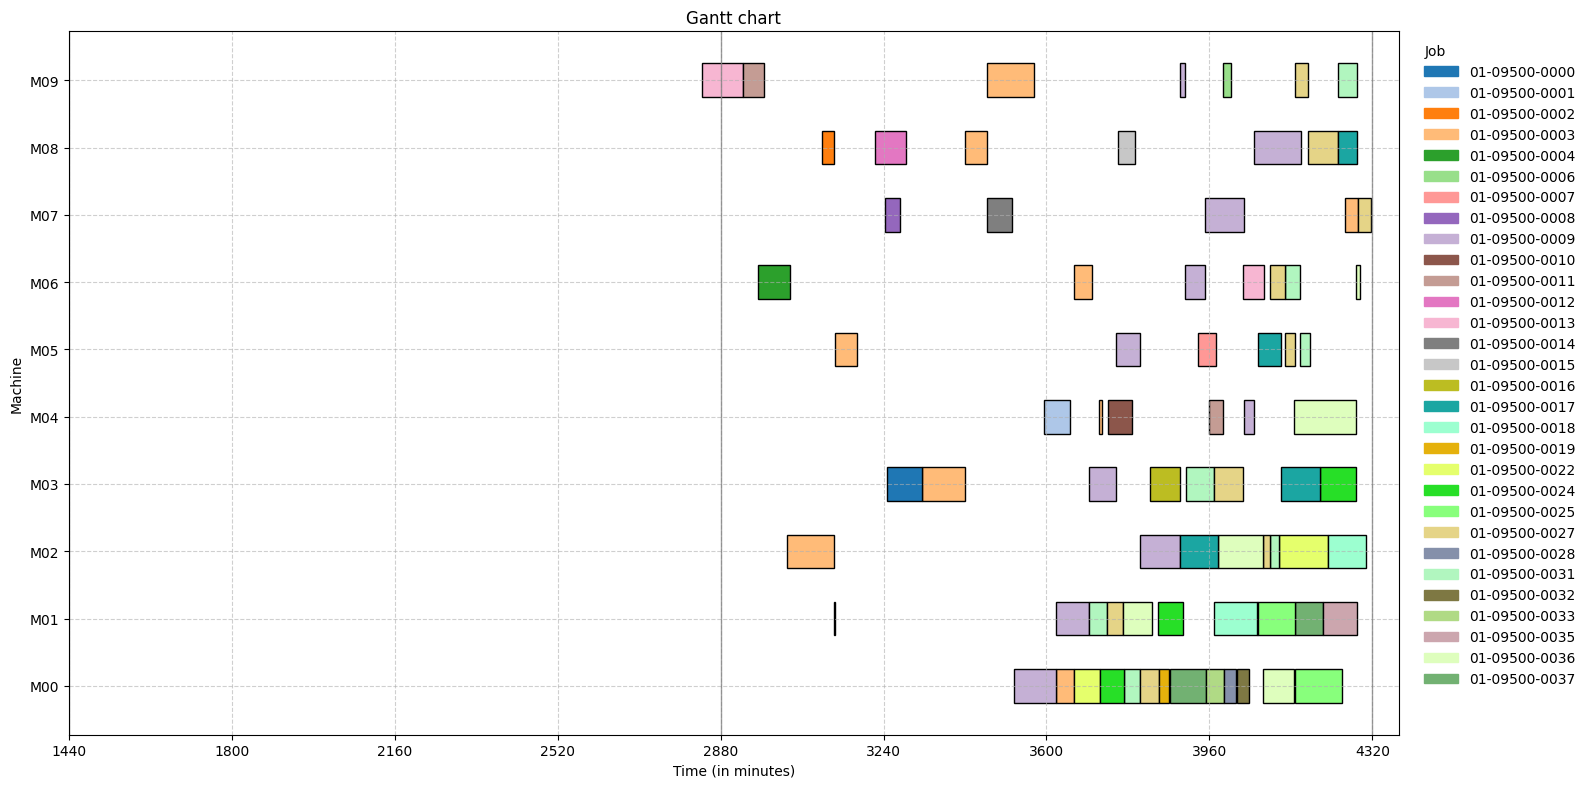

In [44]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution2, perspective="Machine")
plt.show()

#### Check the conditions of the combined data set from the two simulation data sets

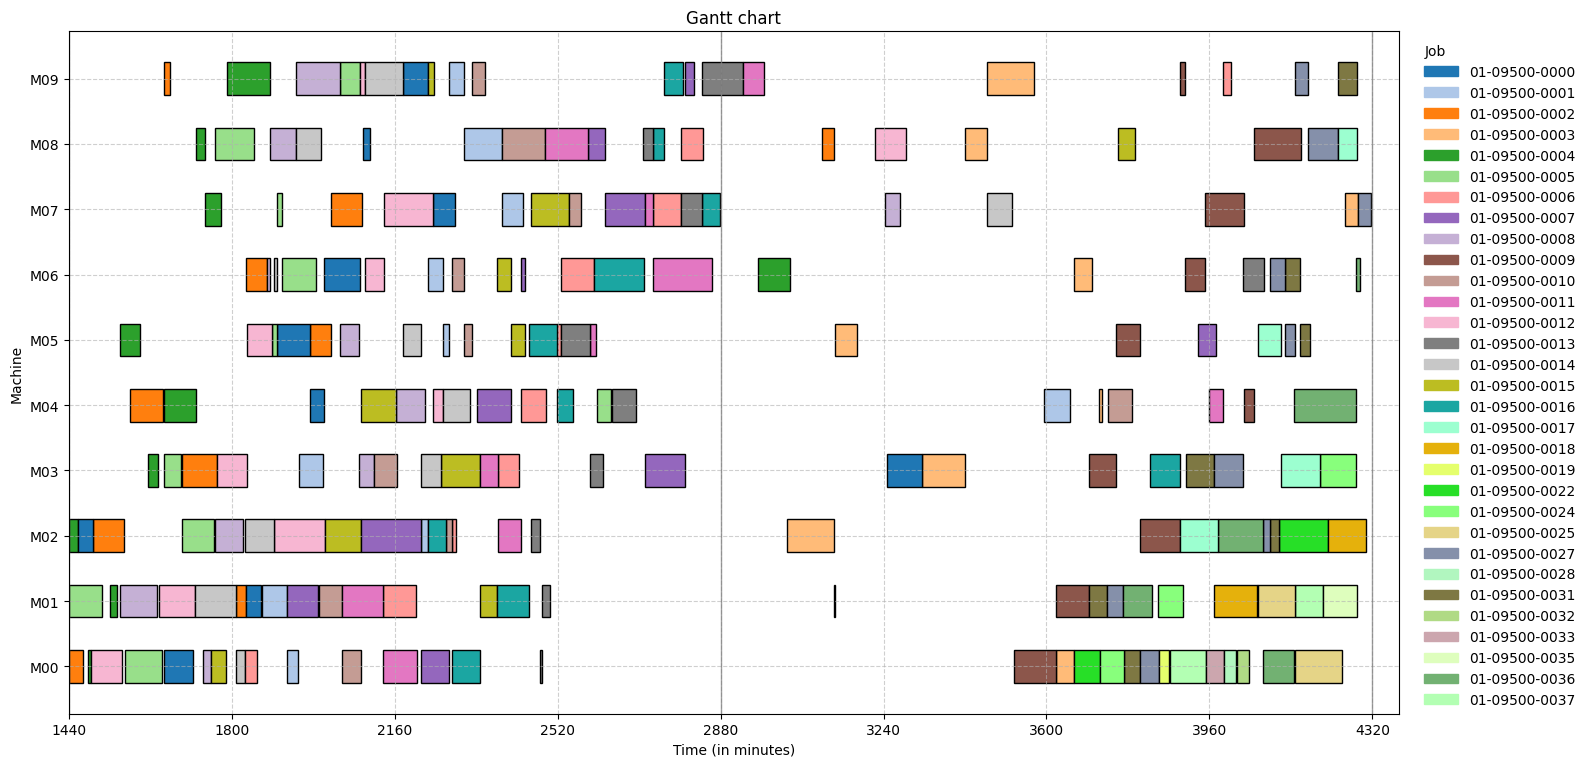

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [45]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)